In [1]:
using EffectSizes, Random, HypothesisTests, StatsPlots, Statistics, Distributions

const TTest = EqualVarianceTTest
const c = get_color_palette(:auto, plot_color(:white), 3)

default(:size, (500,300))
default(:legend, false)

function sampledata(;n, seed=1, Δ=0)
    !isnothing(seed) && Random.seed!(seed)
    randn(n), randn(n) .+ Δ
end

resample(xs) = xs[rand(1:length(xs), length(xs))]

bootstrap(xs, ys, n=1000) = [pvalue(TTest(resample(xs), resample(ys))) for _ = 1:n]

function confidenceinterval(xs; quantile=0.95)
    lq = (1-quantile)/2 # two-tailedness
    uq = quantile+lq
    Distributions.quantile(xs, lq), Distributions.quantile(xs, uq)
end

function simulate(s::Integer; Δ, nboot)
    es = EffectSize[]
    ps = Float64[]
    for _ = 1:nboot
        xs, ys = sampledata(n=s, Δ=Δ, seed=nothing)
        push!(es, EffectSize(xs, ys))
        push!(ps, pvalue(EqualVarianceTTest(xs, ys)))
    end
    es, ps
end

function simulate(sizes::AbstractArray; Δ, nboot)
    es, ps = collect.(zip(map(s->simulate(s, Δ=Δ, nboot=nboot), sizes)...))
end

simulate (generic function with 2 methods)

---

# $P$ values and effect sizes

# Time for $P$ values to P off?

### Harry Scholes, @harryscholes

---

## Scientists rise up against statistical significance.

https://www.nature.com/articles/d41586-019-00857-9

Comment piece in Nature with over 800 signatories calling for urgent reform of hypothesis
testing in scientific research.

## We see this all the time, but what does it mean?

$P < 0.05$

## So, what are $P$ values?

$P$ is the probability that the test statistic is equal to, or more extreme than, the
observed test statistic when the null hypothesis is true.

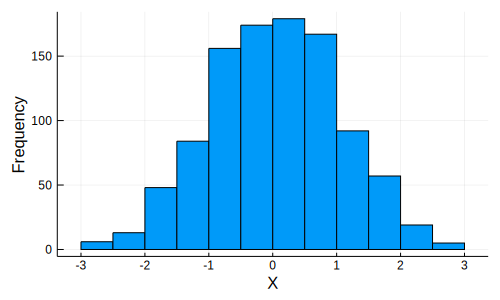

In [2]:
H₀ = randn(1000)
histogram(H₀, xlabel="X", ylabel="Frequency")

In [3]:
obs = 2.1
p = (1 + count(H₀ .≥ obs)) / (1 + length(H₀))

0.02097902097902098

## $P$ values are a measure of how compatible a sample is with a hypothesis.

Are these samples drawn from different distributions?

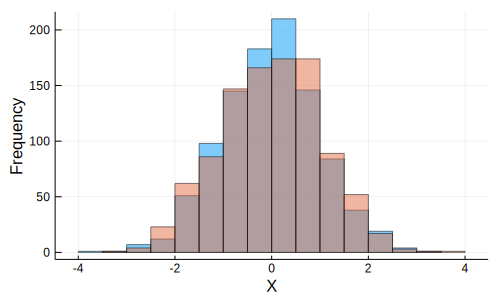

In [4]:
xs, ys = sampledata(n=10^3)

histogram([xs, ys], α=.5, xlabel="X", ylabel="Frequency")

In [5]:
pvalue(TTest(xs, ys))

0.6815135313761379

How about these samples?

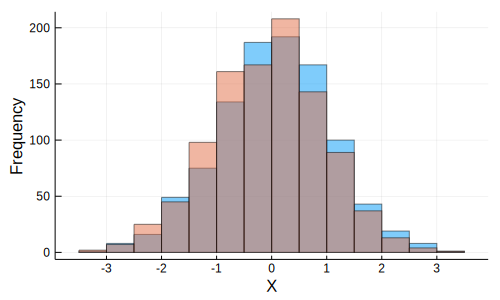

In [6]:
xs, ys = sampledata(n=10^3, seed=16)

histogram([xs, ys], α=.5, xlabel="X", ylabel="Frequency")

In [7]:
pvalue(TTest(xs, ys))

0.004831270662304761

## $P$ values are random variables.

Let's do a simulation to demonstrate this:

* Sample from a normal distribution with mean $\mu = 0.5$
* Perform a t-test of the hypothesis

$H_0 : \mu \le \mu{_0} $

$H_a : \mu > \mu{_0} $

* Repeat 10,000 times

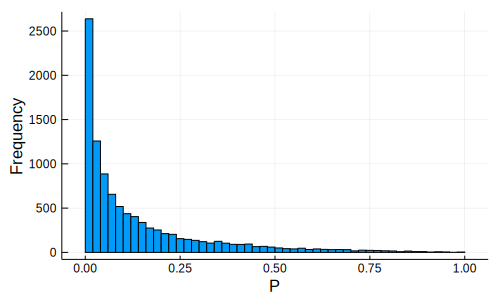

In [8]:
μ  = 0.5  # sample mean
μ₀ = 0    # population mean

samples = [rand(Normal(μ), 10) for _ = 1:10^4]
ttests = OneSampleTTest.(samples, μ₀)
pvalues = pvalue.(ttests, tail=:right)

histogram(pvalues, xlabel="P", ylabel="Frequency")

## $P$ values are not a measure of the truth of a hypothesis.

Let's also simulate this, but this time we'll sample from a normal distribution with mean $\mu = 0$

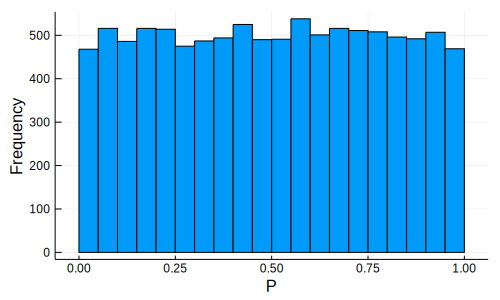

In [9]:
μ  = 0  # sample mean
μ₀ = 0  # population mean

samples = [rand(Normal(μ), 10) for _ = 1:10^4]
ttests = OneSampleTTest.(samples, μ₀)
pvalues = pvalue.(ttests, tail=:right)

histogram(pvalues, xlabel="P", ylabel="Frequency")

When the null hypothesis is true, $P$ values are uniformly distributed $U(0,1)$.

## Misconceptions of $P$ values:

* If $P > \alpha$, you can never conclude that there is "no difference" or "no association".

* If $P < \alpha$, you can never accept the alternative hypothesis.

## $P$ values conflate effect size and sample size.

Let's compare large samples from two similar distributions. What's the $P$ value?

In [10]:
xs, ys = sampledata(n=10^5, Δ=0.01)

pvalue(TTest(xs, ys))

0.027003357705875367

$P < 0.05$, so let's publish the results!

Let's make the figure for the paper:

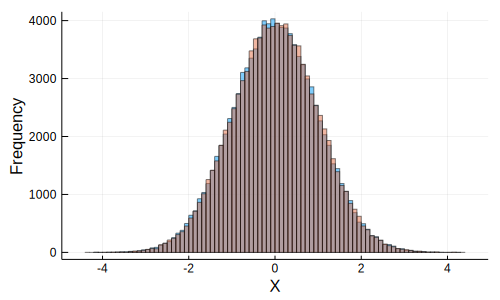

In [11]:
histogram([xs, ys], α=.5, xlabel="X", ylabel="Frequency")

## Oh... 💩

How confident are we that our result is significant? Confidence intervals can be assigned using bootstrap resampling:

In [12]:
confidenceinterval(bootstrap(xs, ys, 100), quantile=0.95)

(0.00015540409140372413, 0.6913353330776159)

## Okay, so what do we mean by 'significance'?

In reality, we do not _actually_ care if $P < 0.05$. What we really care about the effect size.

For example, take a drug that extends lifespan with $P << 0.05$. Is it worth spending
$2 billion to develop this drug if the effect size of the lifespan extension is one month?

---

## Effect size

The effect size index is a dimensionless quantity.

One formula is Cohen's $d$:

$d = \frac{m_A - m_B}{s}$

where

$s = \sqrt{\frac{(n_A - 1) s_A^2 + (n_B - 1) s_B^2}{n_A + n_B - 2}}$

Effect | Effect size
:---|---:
Small | 0.2
Medium | 0.5
Large | 0.8

## EffectSizes.jl

https://github.com/harryscholes/EffectSizes.jl

- Cohen's $d$
- Hedge's $g$
- Glass's $\Delta$
- Confidence intervals
    - Normal
    - Bootstrap

In [13]:
# Installation:
# using Pkg
# Pkg.add("EffectSizes")

In [14]:
using EffectSizes

## Small effects:

pvalue(TTest(xs, ys)) = 0.045745710343755124


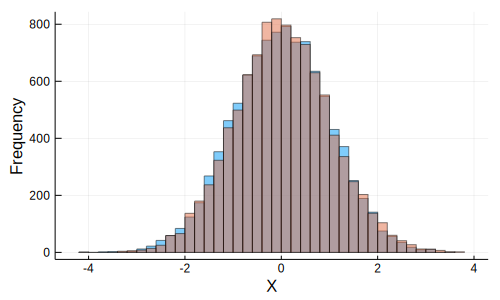

In [15]:
xs, ys = sampledata(n=10^4, seed=6)

@show pvalue(TTest(xs, ys))
histogram([xs, ys], α=.5, xlabel="X", ylabel="Frequency")

Let's see what the effect size is and assign bootstrap confidence intervals:

In [16]:
EffectSize(xs, ys, 10^3, quantile=0.95)

-0.028, 0.95CI (-0.055, 0.0)

According to $P$ the result is significant, but according to $d$ there is no effect.

## Large effects:

pvalue(TTest(xs, ys)) = 0.0
confidenceinterval(bootstrap(xs, ys, 10 ^ 3), quantile=0.95) = (0.0, 0.0)
EffectSize(xs, ys, 10 ^ 3, quantile=0.95) = -0.989, 0.95CI (-1.02, -0.962)


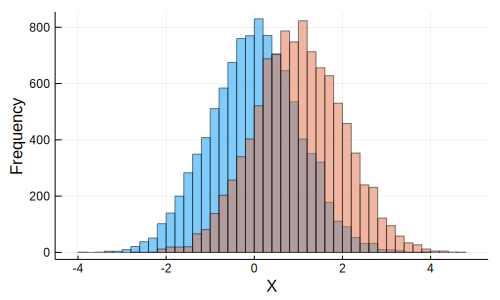

In [17]:
xs, ys = sampledata(n=10^4, Δ=1)

@show pvalue(TTest(xs, ys))
@show confidenceinterval(bootstrap(xs, ys, 10^3), quantile=0.95)
@show EffectSize(xs, ys, 10^3, quantile=0.95)
histogram([xs, ys], α=.5, xlabel="X", ylabel="Frequency")

## Comparison of $P$ values and effect sizes

Let's compare $P$ values and effect sizes for samples:
* Drawn from similar distributions.
* With different sample sizes.

In [18]:
samplesizes = 10 .^ (1:6)

6-element Array{Int64,1}:
      10
     100
    1000
   10000
  100000
 1000000

In [19]:
es, ps = simulate(samplesizes, Δ=0.01, nboot=100);

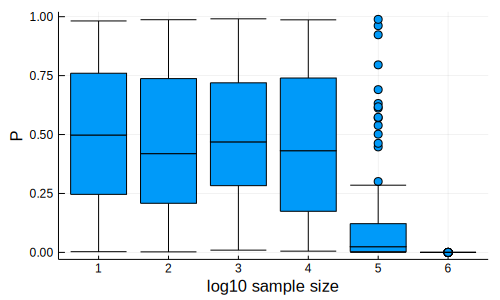

In [20]:
boxplot(ps, xlabel="log10 sample size", ylabel="P", c=c[1])

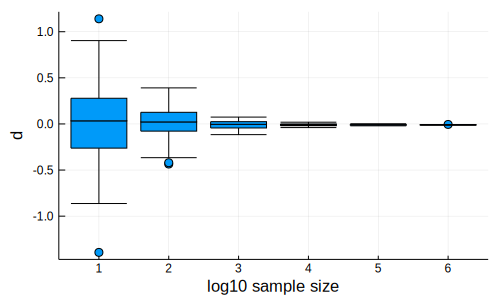

In [21]:
boxplot(map(x->effectsize.(x), es), xlabel="log10 sample size", ylabel="d", c=c[1])

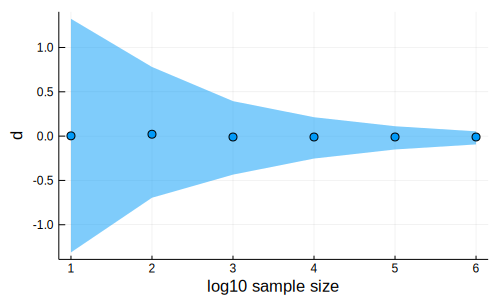

In [22]:
scatter(map(x->mean(effectsize.(x)), es),
        ribbon=(map(x->mean(lower.(confint.(x))), es) .* -1,
                map(x->mean(upper.(confint.(x))), es)),
        xlabel="log10 sample size", ylabel="d", c=c[1])

## Conclusions

Retire significance, but still test hypotheses

https://www.nature.com/articles/d41586-019-00972-7

>Testing establishes whether there is an effect, and that helps to determine whether or not
the magnitude needs to be estimated. … What happens when statistical testing is skipped and
the null hypothesis is ignored? Well, noise would be interpreted as structural, and any
differences between observations would be considered meaningful.

## Further reading

### $P$ values
- Interpreting $P$ values https://www.nature.com/articles/nmeth.4210

- $P$ values and the search for significance https://www.nature.com/articles/nmeth.4120

- $P$ values are random variables https://www.tandfonline.com/doi/abs/10.1198/000313008X332421

### Effect sizes
- Statistical Power Analysis for the Behavioral Sciences http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf
- Tutorials
    - https://www.leeds.ac.uk/educol/documents/00002182.htm
    - http://staff.bath.ac.uk/pssiw/stats2/page2/page14/page14.html